In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from collections import OrderedDict
import pickle
from datetime import datetime
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve,roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score
import xgboost as xgb

In [14]:
TLC_df = pd.read_csv('data\\TLC_df_final.csv')
df_fico_grade = pd.read_csv('data\\grade_to_fico.csv')
df_fico_apr = pd.read_csv('data\\grade_to_apr.csv')

#TLC_df = pd.read_csv('/content/drive/MyDrive/TLC_df_final.csv')
#df_fico_grade = pd.read_csv('/content/drive/MyDrive/grade_to_fico.csv')
#df_fico_apr = pd.read_csv('/content/drive/MyDrive/grade_to_apr.csv')

with open('models\\knn_regression_grade.pkl', 'rb') as f:
    knn = pickle.load(f)

with open('models\\knn_funded_amnt.pkl', 'rb') as f:
    knn_fa = pickle.load(f)

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator KNeighborsRegressor from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [15]:
target = 'loan_status'


X = TLC_df.drop(columns=[target,'zip_3','zip_2','Unnamed: 0'], axis=1)
y = TLC_df[target]

In [16]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=11)

In [17]:
drop_columns=['pub_rec','pub_rec_bankruptcies','purpose','revol_bal','total_acc']

In [18]:
X_train=X_train.drop(columns=drop_columns)
X_test =X_test.drop(columns=drop_columns)

In [19]:
rf_clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=11)

rf_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=11)

In [20]:
y_pred = rf_clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[298458,   6741],
       [ 77546,   7843]], dtype=int64)

In [21]:
result = rf_clf.score(X_test, y_test)
print(result)

0.7842048398824336


In [22]:
rf_auc = roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:,1])
print("rf_auc: {}".format(rf_auc))

rf_auc: 0.7048877796537023


In [3]:
# save the model to disk
with open('models\\rf_model_final.sav', 'wb') as handle:
    pickle.dump(rf_clf,
                handle,
                protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'rf_clf' is not defined

In [26]:
# load the model from disk
with open('rf_model_final.sav', 'rb') as f:
    rf = pickle.load(f)

In [27]:
result = rf.score(X_test, y_test)
print(result)

0.6259127264534496


In [28]:
fpr, tpr, thresholds = roc_curve(y_test,rf.predict_proba(X_test)[:,1],pos_label=1)

In [29]:
precision, recall, thresholds = precision_recall_curve(y_test,
                                                       rf.predict_proba(X_test)[:,1],
                                                       pos_label=1)

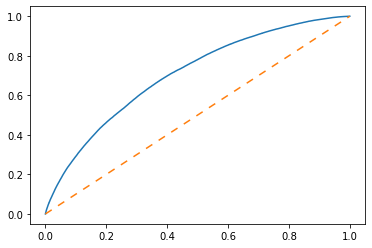

In [30]:
plt.plot(fpr, tpr, label='RF')
plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
plt.show()

In [31]:
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
print("rf_auc: {}".format(rf_auc))

rf_auc: 0.7058385353704272


In [32]:
f1_rf = f1_score(y_test, y_pred)

print("f1_xgb (binary): {}\n".format(f1_rf))
print(classification_report(y_test,y_pred))

f1_xgb (binary): 0.1569023636381823

              precision    recall  f1-score   support

           0       0.79      0.98      0.88    305199
           1       0.54      0.09      0.16     85389

    accuracy                           0.78    390588
   macro avg       0.67      0.53      0.52    390588
weighted avg       0.74      0.78      0.72    390588



In [33]:
y_pred = rf.predict(X_test)

In [34]:
# calculate AUC
auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)

AUC: 0.649


In [36]:
CATEGORIES = ["LOAN ISSUED","LOAN DENIED"]

In [58]:
#get input for accept
fico = 677
loan_amnt = 3600
term = '36 months'
dti = 5.91
home_ownership = 'MORTGAGE'
mort_acc = 1
annual_inc = 55000
open_acc = 12
employment_length = 10
verification_status = 0
revol_util = 29.7
total_acc = 13
credit_hist = 5505

In [48]:
#get input for deny
fico = 662
loan_amnt = 24000
term = '60 months'
dti = 18.30
home_ownership = 'rent'
mort_acc = 2
annual_inc = 110000
open_acc = 10
employment_length = 6
verification_status = 0
revol_util = 68.1
total_acc = 31
credit_hist = 6302

In [59]:
funded_amnt = knn_fa.predict(np.reshape([loan_amnt], (1,-1)))[0]
funded_amnt

3600.0

In [60]:
#calculate grade from FICO
sub_grade = knn.predict(np.reshape([fico], (1,-1)))[0]
#calculate grade
grade = round(sub_grade/5) + 1
#get interest rate
apr_row = df_fico_apr[df_fico_apr['grade_num']==sub_grade]

In [61]:
if term=='36 months':
    int_rate = apr_row['36_mo'].values[0]
    installment = float(loan_amnt)/36
            
else:
    int_rate = apr_row['60_mo'].values[0]
    installment = float(loan_amnt)/60

In [62]:
term_to_int = {'36 months': 1, '60 months': 2}
home_to_int = {'MORTGAGE': 4, 'RENT': 3, 'OWN': 5,'ANY': 2,'OTHER': 1, 'NONE':0 }

In [63]:
temp = pd.DataFrame(index=[1])
temp['loan_amnt']=loan_amnt
temp['funded_amnt']=funded_amnt
temp['term']=term_to_int[term]
temp['int_rate']=int_rate
temp['grade']=grade
temp['sub_grade']=sub_grade
temp['emp_length']=employment_length
temp['home_ownership']=home_to_int[home_ownership.upper()]
temp['annual_inc']=annual_inc
temp['verification_status']=verification_status
temp['dti']=dti
temp['open_acc'] = open_acc
temp['revol_util']=revol_util
temp['mort_acc'] = mort_acc
temp['credit_hist']=credit_hist
temp['fico_avg_score'] = fico
temp['inst_amnt_ratio']=installment/loan_amnt

In [64]:
X_train.columns

Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'dti', 'open_acc', 'revol_util', 'mort_acc', 'credit_hist',
       'fico_avg_score', 'inst_amnt_ratio'],
      dtype='object')

In [65]:
temp.columns

Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'dti', 'open_acc', 'revol_util', 'mort_acc', 'credit_hist',
       'fico_avg_score', 'inst_amnt_ratio'],
      dtype='object')

In [66]:
temp

,loan_amnt,funded_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,dti,open_acc,revol_util,mort_acc,credit_hist,fico_avg_score,inst_amnt_ratio
1,3600,3600.0,1,21.49,5,19.0,10,4,55000,0,5.91,12,29.7,1,5505,677,0.027778


In [67]:
Result = rf.predict(temp)
print(CATEGORIES[int(Result)])

LOAN DENIED
